[← Previous: Random Forest Classification](07_text_classification_random_forest.ipynb)

# Building a Logistic Regression Classifier for Anxiety Trigger Detection

**Goal:** Evaluate whether a linear classifier (Logistic Regression) can predict posts that trigger high anxiety.

**Approach:** Mirror the Random Forest pipeline with identical data sources, features (TF-IDF + NMF topics + metadata), and three label strategies (hand, AI, combined).

**Why Logistic Regression?** Strong baseline for high-dimensional sparse text features; fast to train, interpretable coefficients, and often competitive with tree ensembles for linear-separable patterns.


---


## Table of Contents

1. [Setup](#1-setup)
2. [Load Pre-trained Models](#2-load-pre-trained-models)
3. [Create Three Label Sets](#3-create-three-label-sets)
4. [Build Features](#4-build-features)
5. [Train and Compare](#5-train-and-compare)
6. [Save Model for Production](#6-save-model-for-production)
7. [Generate Report Statistics](#7-generate-report-statistics)
8. [Limitations and Future Work](#8-limitations-and-future-work)

[Next: TODO →]


---


In [1]:
%pip install -r ../requirements.txt


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '<<<<<<< Updated upstream': Expected package name at the start of dependency specifier
    <<<<<<< Updated upstream
    ^ (from line 15 of ../requirements.txt)


---


## **1. Setup**

Import libraries, set paths, define random seed for reproducibility.


In [2]:
# ============================================================================
# SETUP AND IMPORTS
# ============================================================================

# Standard Library
import os
import json
import warnings
from pathlib import Path

# Data Processing
import numpy as np
import pandas as pd
import joblib

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Evaluation Metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

# Sparse Matrix Operations
from scipy.sparse import hstack, csr_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
SEED = 42
np.random.seed(SEED)
warnings.filterwarnings("ignore")

# Project Paths
DATA = Path("../data")
PROC = DATA / "processed"
ART = Path("../artifacts")

# Tokenization rules (mirroring RF notebook)
TEXT_COL = "text_all"
PUNCT = ".,!?:;()[]{}\"'" "''-–—/\\"
TRASH = {"[text]", "[image]", "[removed]", "[deleted]"}
KEEP_SHORT = {"ecg", "sad", "ptsd", "mom", "dad", "anx"}


def tokenize(s: str):
    tokens = []
    for word in str(s).split():
        word = word.strip().strip(PUNCT).lower()
        if word and word not in TRASH and (len(word) >= 3 or word in KEEP_SHORT):
            tokens.append(word)
    return tokens


print("(\u2713) Setup complete")
print(f"  - Data path: {PROC}")
print(f"  - Artifacts path: {ART}")
print(f"  - Random seed: {SEED}")
print(f"  - Tokenization: {len(KEEP_SHORT)} special terms preserved")

(✓) Setup complete
  - Data path: ..\data\processed
  - Artifacts path: ..\artifacts
  - Random seed: 42
  - Tokenization: 6 special terms preserved


---


## **2. Load Pre-trained Models**

Load main dataset, pre-trained TF-IDF and NMF components, and both label sources.


In [3]:
# ============================================================================
# LOAD DATA AND ARTIFACTS
# ============================================================================


def identity(x):
    return x


# Main dataset
df = pd.read_parquet(PROC / "reddit_anxiety_v1.parquet")
print(f"(\u2713) Main dataset: {len(df):,} posts")

# Pre-trained artifacts
vec = joblib.load(ART / "vec_final.joblib")
print(f"(\u2713) TF-IDF Vectorizer: {vec.max_features:,} features")

nmf = joblib.load(ART / "nmf_final.joblib")
print(f"(\u2713) NMF Topic Model: {nmf.n_components} topics")

# Label sources
df_hand = pd.read_csv(PROC / "sample_human_labels.csv")
print(f"(\u2713) Hand labels: {len(df_hand):,} posts")

df_ai = pd.read_csv(PROC / "simple_ai_labels.csv")
print(f"(\u2713) AI labels: {len(df_ai):,} posts")

print("\n...DATA LOADED SUCCESSFULLY...")

(✓) Main dataset: 6,283 posts
(✓) TF-IDF Vectorizer: 10,000 features
(✓) NMF Topic Model: 15 topics
(✓) Hand labels: 599 posts
(✓) AI labels: 1,000 posts

...DATA LOADED SUCCESSFULLY...


In [4]:
# ============================================================================
# VERIFICATION: CHECK FEATURE DIMENSIONS
# ============================================================================

print("FEATURE DIMENSION VERIFICATION\n")

print(
    f"1. TF-IDF Vectorizer:\n   - Loaded from: {ART / 'vec_final.joblib'}\n   - Max features: {vec.max_features:,}\n"
)

print(
    f"2. NMF Topic Model:\n   - Loaded from: {ART / 'nmf_final.joblib'}\n   - Number of topics: {nmf.n_components}\n"
)

sample_text = df[TEXT_COL].iloc[0]
sample_tokens = tokenize(sample_text)

X_tfidf_sample = vec.transform([sample_tokens])
W_topics_sample = nmf.transform(X_tfidf_sample)

doc_len_val = len(sample_tokens)
has_url_val = int("http" in sample_text.lower())
nrc_val = df.get("anxiety_score", pd.Series(0)).iloc[0]

print(
    f"3. Feature Matrix Dimensions (for 1 sample):\n   - TF-IDF shape: {X_tfidf_sample.shape}\n   - NMF topics shape: {W_topics_sample.shape}\n   - Metadata features: 3 (len={doc_len_val}, url={has_url_val}, nrc={nrc_val:.3f})\n"
)

total_features = X_tfidf_sample.shape[1] + W_topics_sample.shape[1] + 3
print(f"TOTAL FEATURE COUNT: {total_features:,} features")

FEATURE DIMENSION VERIFICATION

1. TF-IDF Vectorizer:
   - Loaded from: ..\artifacts\vec_final.joblib
   - Max features: 10,000

2. NMF Topic Model:
   - Loaded from: ..\artifacts\nmf_final.joblib
   - Number of topics: 15

3. Feature Matrix Dimensions (for 1 sample):
   - TF-IDF shape: (1, 10000)
   - NMF topics shape: (1, 15)
   - Metadata features: 3 (len=164, url=0, nrc=0.000)

TOTAL FEATURE COUNT: 10,018 features


---


## **3. Create Three Label Sets**

Hand-annotated, AI-generated, and a combined set prioritizing hand labels on overlap.


In [5]:
# ============================================================================
# CREATE LABEL SETS FOR MODEL TRAINING
# ============================================================================

label_sets = {}

# Hand labels
print("Processing HAND labels...")
df_h = df_hand[["post_id"]].copy()
if "anxiety_rating" in df_hand.columns:
    rating = pd.to_numeric(df_hand["anxiety_rating"], errors="coerce")
    df_h["label"] = (rating >= 4).astype(int)
else:
    raise ValueError("anxiety_rating column not found in hand-annotated data")
print(
    f"  Hand: {len(df_h)} posts (pos: {df_h['label'].sum()}, {100*df_h['label'].mean():.1f}%)"
)
label_sets["hand"] = df_h

# AI labels
print("Processing AI labels...")
cat = df_ai["ai_category"].astype(str).str.lower()
conf = pd.to_numeric(df_ai["ai_confidence"], errors="coerce").fillna(0)
sev = pd.to_numeric(df_ai["ai_severity"], errors="coerce").fillna(0)

df_a = df_ai[["post_id"]].copy()
df_a["label"] = (
    (cat.str.contains("anx") | cat.str.contains("panic")) & (sev >= 4) & (conf >= 0.5)
).astype(int)
print(
    f"  AI: {len(df_a)} posts (pos: {df_a['label'].sum()}, {100*df_a['label'].mean():.1f}%)"
)
label_sets["ai"] = df_a

# Combined (prioritize hand)
print("Combining labels...")
df_h_temp = df_h.copy()
df_h_temp["source"] = "hand"
df_a_temp = df_a.copy()
df_a_temp["source"] = "ai"

df_comb = pd.concat([df_h_temp, df_a_temp], ignore_index=True)
df_comb = df_comb.sort_values("source").drop_duplicates("post_id", keep="last")
print(
    f"  Combined: {len(df_comb)} posts (pos: {df_comb['label'].sum()}, {100*df_comb['label'].mean():.1f}%)"
)
label_sets["combined"] = df_comb[["post_id", "label"]]

print(f"\n\u2713 Created 3 label sets: {list(label_sets.keys())}")

Processing HAND labels...
  Hand: 599 posts (pos: 114, 19.0%)
Processing AI labels...
  AI: 1000 posts (pos: 147, 14.7%)
Combining labels...
  Combined: 1006 posts (pos: 173, 17.2%)

✓ Created 3 label sets: ['hand', 'ai', 'combined']


## **4. Build Features**

Use the same three-part feature composition: TF-IDF, NMF topic distributions, and metadata (doc length, URL flag, NRC anxiety score).


In [6]:
# ============================================================================
# BUILD FEATURES FOR EACH LABEL SET
# ============================================================================

datasets = {}

for name, df_labels in label_sets.items():
    # Match and merge labels
    df_subset = df[df["post_id"].isin(df_labels["post_id"])].copy()
    df_subset = df_subset.merge(df_labels, on="post_id", how="inner")

    # Tokenize
    tokens = df_subset[TEXT_COL].fillna("").map(tokenize)

    # Feature 1: TF-IDF
    X_tfidf = vec.transform(tokens)

    # Feature 2: NMF topics
    W_topics = nmf.transform(X_tfidf)

    # Feature 3: Metadata
    doc_len = np.array([len(t) for t in tokens])[:, None]
    has_url = (
        df_subset[TEXT_COL]
        .fillna("")
        .str.contains("http", case=False)
        .astype(int)
        .values[:, None]
    )
    nrc = (
        df_subset.get("anxiety_score", pd.Series(0, index=df_subset.index))
        .fillna(0)
        .values[:, None]
    )

    # Combine
    X_dense = np.hstack([W_topics, doc_len, has_url, nrc])
    X_dense = np.nan_to_num(X_dense, nan=0.0)
    X = hstack([X_tfidf, csr_matrix(X_dense)], format="csr")
    X.data = np.nan_to_num(X.data, nan=0.0)

    y = df_subset["label"].values
    datasets[name] = {"X": X, "y": y}

    print(
        f"{name:10s} | X: {X.shape} | y: {len(y):4d} (pos: {y.sum():3d}, {100*y.mean():4.1f}%)"
    )

print(f"\n\u2713 Built features for all 3 datasets")

hand       | X: (599, 10018) | y:  599 (pos: 114, 19.0%)
ai         | X: (1000, 10018) | y: 1000 (pos: 147, 14.7%)
combined   | X: (1006, 10018) | y: 1006 (pos: 173, 17.2%)

✓ Built features for all 3 datasets


## **5. Train and Compare**

Method: 80/20 split, Logistic Regression (liblinear/saga), optimize F1 threshold. Mirrors RF notebook for fair comparison.


In [7]:
# ============================================================================
# TRAIN LOGISTIC REGRESSION ON EACH LABEL SOURCE
# ============================================================================

results = []

for name in ["hand", "ai", "combined"]:
    print(f"\nTRAINING: {name.upper()}")
    print("=" * 60)

    X = datasets[name]["X"]
    y = datasets[name]["y"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=SEED
    )

    print(f"Train: {len(y_train)} samples | Test: {len(y_test)} samples")
    print(
        f"Class balance - Train: {y_train.mean():.1%} | Test: {y_test.mean():.1%} positive"
    )

    # Logistic Regression (works well on high-dim sparse TF-IDF)
    clf = LogisticRegression(
        solver="liblinear",  # robust on small, imbalanced datasets
        penalty="l2",
        class_weight="balanced",  # handle ~15-20% positives
        max_iter=2000,
    )

    print("\nTraining Logistic Regression...")
    clf.fit(X_train, y_train)

    proba = clf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)

    p, r, t = precision_recall_curve(y_test, proba)
    f1 = 2 * p * r / (p + r + 1e-10)
    best_thr = t[np.argmax(f1)] if len(t) else 0.5

    y_pred = (proba >= best_thr).astype(int)

    print(f"\nPerformance Metrics:")
    print(f"  AUC: {auc:.3f}")
    print(f"  Average Precision: {ap:.3f}")
    print(f"  Optimal threshold (max F1): {best_thr:.3f}")
    print(f"\nClassification Report at threshold {best_thr:.3f}:")
    print(
        classification_report(
            y_test, y_pred, digits=3, target_names=["Low Anxiety", "High Anxiety"]
        )
    )

    results.append(
        {
            "source": name,
            "n": len(y),
            "pos_rate": y.mean(),
            "auc": auc,
            "ap": ap,
            "threshold": float(best_thr),
            "model": clf,
        }
    )

# Comparison table
_df_results = (
    pd.DataFrame(results).sort_values("auc", ascending=False).reset_index(drop=True)
)
print("\n" + "=" * 60)
print("FINAL COMPARISON: Label Source Performance")
print("=" * 60)
print(
    _df_results[["source", "n", "pos_rate", "auc", "ap", "threshold"]].to_string(
        index=False
    )
)
print("\n" + "=" * 60)

# Save comparison
cmp_path = ART / "label_comparison_logreg.csv"
_df_results.to_csv(cmp_path, index=False)
print(f"\n\u2713 Saved comparison results to: {cmp_path}")

# Expose for later cells
df_results = _df_results


TRAINING: HAND
Train: 479 samples | Test: 120 samples
Class balance - Train: 19.0% | Test: 19.2% positive

Training Logistic Regression...

Performance Metrics:
  AUC: 0.870
  Average Precision: 0.656
  Optimal threshold (max F1): 0.571

Classification Report at threshold 0.571:
              precision    recall  f1-score   support

 Low Anxiety      0.933     0.866     0.898        97
High Anxiety      0.567     0.739     0.642        23

    accuracy                          0.842       120
   macro avg      0.750     0.803     0.770       120
weighted avg      0.863     0.842     0.849       120


TRAINING: AI
Train: 800 samples | Test: 200 samples
Class balance - Train: 14.8% | Test: 14.5% positive

Training Logistic Regression...

Performance Metrics:
  AUC: 0.840
  Average Precision: 0.461
  Optimal threshold (max F1): 0.529

Classification Report at threshold 0.529:
              precision    recall  f1-score   support

 Low Anxiety      0.944     0.789     0.860       171
High

#### **Visualize Label Source Comparison**


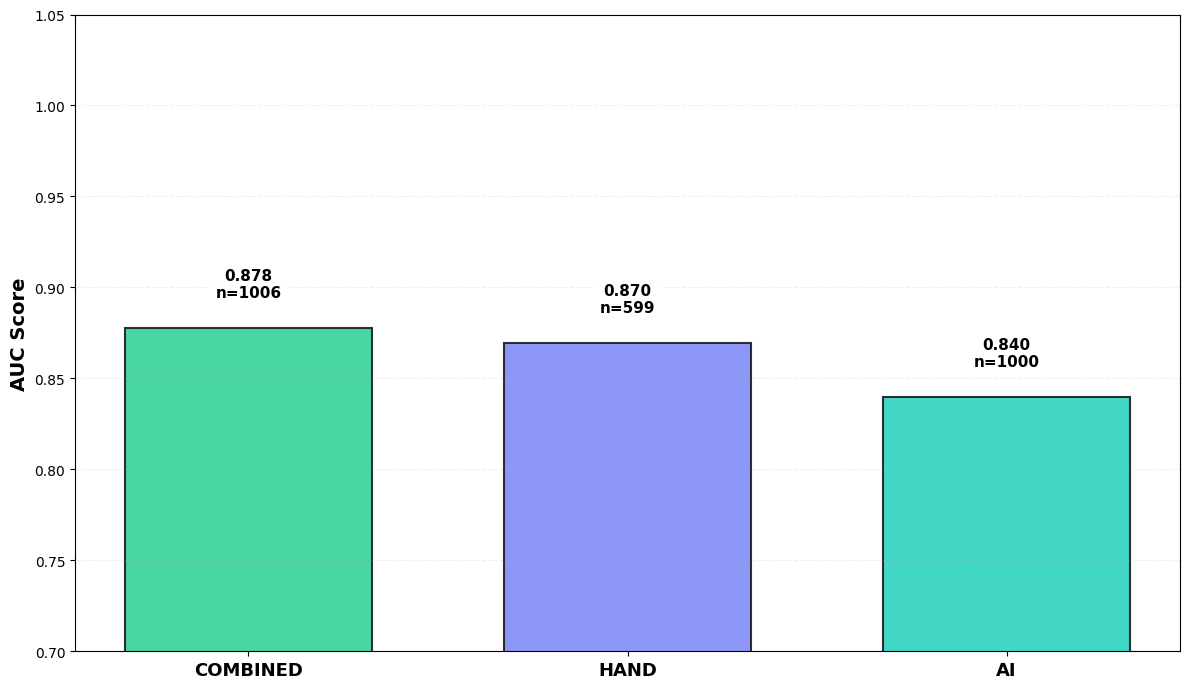

✓ Saved visualization: ..\artifacts\images\final_comparison_logreg.png


In [8]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 7))
colors = {"hand": "#818CF8", "ai": "#2DD4BF", "combined": "#34D399"}

x_positions = np.arange(len(df_results))
ax.bar(
    x_positions,
    df_results["auc"],
    color=[colors[s] for s in df_results["source"]],
    width=0.65,
    edgecolor="#1a1a1a",
    linewidth=1.5,
    alpha=0.9,
)

ax.set_xticks(x_positions)
ax.set_xticklabels(
    [s.upper() for s in df_results["source"]], fontsize=13, fontweight="bold"
)
ax.set_ylabel("AUC Score", fontsize=14, fontweight="bold")
ax.set_ylim([0.70, 1.0])
ax.set_yticks(np.arange(0.70, 1.05, 0.05))
ax.grid(axis="y", alpha=0.2, linestyle="--", linewidth=0.8)

for i, (_, row) in enumerate(df_results.iterrows()):
    ax.text(
        i,
        row["auc"] + 0.015,
        f'{row["auc"]:.3f}\nn={int(row["n"])}',
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=11,
        bbox=dict(
            boxstyle="round,pad=0.5", facecolor="white", edgecolor="none", alpha=0.8
        ),
    )

plt.tight_layout()
img_path = ART / "images/final_comparison_logreg.png"
img_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(img_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print(f"\u2713 Saved visualization: {img_path}")

## **6. Save Model for Production**

Retrain the combined-label model on the full dataset and save artifacts (separate filenames from RF).


In [9]:
# ============================================================================
# RETRAIN BEST MODEL (COMBINED) ON FULL DATASET AND SAVE
# ============================================================================

print("Retraining logistic regression (COMBINED) on full dataset...")
X_full = datasets["combined"]["X"]
y_full = datasets["combined"]["y"]

print(f"  Training samples: {len(y_full):,}")
print(f"  Positive class: {y_full.sum()} ({100*y_full.mean():.1f}%)")

best_model = LogisticRegression(
    solver="liblinear",
    penalty="l2",
    class_weight="balanced",
    max_iter=4000,
)

print("\nTraining...")
best_model.fit(X_full, y_full)
print("\u2713 Training complete")

# Save model and metadata
model_path = (
    ART / "logreg_multiclass_pipe.joblib"
    if len(np.unique(y_full)) > 2
    else ART / "logreg_binary_pipe.joblib"
)
joblib.dump(best_model, model_path)

metadata = {
    "model_type": "LogisticRegression",
    "label_source": "combined (hand + AI)",
    "training_info": {
        "n_samples": int(len(y_full)),
        "n_positive": int(y_full.sum()),
        "positive_rate": float(y_full.mean()),
    },
    "performance": {
        "validation": (
            df_results[df_results["source"] == "combined"][
                ["auc", "ap", "threshold"]
            ].to_dict("records")[0]
            if (df_results["source"] == "combined").any()
            else {}
        )
    },
    "features": {
        "tfidf_vocab_size": int(getattr(vec, "max_features", 0)),
        "nmf_topics": int(getattr(nmf, "n_components", 0)),
        "metadata_features": 3,
        "total_features": int(
            (getattr(vec, "max_features", 0) or 0) + getattr(nmf, "n_components", 0) + 3
        ),
    },
    "preprocessing": {
        "vectorizer_path": "vec_final.joblib",
        "nmf_model_path": "nmf_final.joblib",
        "text_column": TEXT_COL,
    },
    "date_trained": pd.Timestamp.now().isoformat(),
    "random_seed": SEED,
}

meta_path = ART / "triggerlens_logreg_model_meta.json"
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\n\u2713 Model saved to: {model_path}")
print(f"\u2713 Metadata saved to: {meta_path}")

Retraining logistic regression (COMBINED) on full dataset...
  Training samples: 1,006
  Positive class: 173 (17.2%)

Training...
✓ Training complete

✓ Model saved to: ..\artifacts\logreg_binary_pipe.joblib
✓ Metadata saved to: ..\artifacts\triggerlens_logreg_model_meta.json


## **7. Generate Report Statistics**

Summarize datasets and validation metrics; save a concise report file.


In [10]:
# Summary and report
print("\n Dataset Summary:")
print(f"  Total posts collected: {len(df):,}")
print(f"  Labeled posts (combined): {len(datasets['combined']['y']):,}")
print(f"  - Hand-labeled: {len(datasets['hand']['y'])}")
print(f"  - AI-labeled: {len(datasets['ai']['y']) - len(datasets['hand']['y'])}")

print("\n Model Performance (Validation):")
print(df_results[["source", "auc", "ap", "threshold", "n"]].to_string(index=False))

report_path = ART / "report_statistics_logreg.txt"
with open(report_path, "w") as f:
    f.write("Logistic Regression Statistics\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Total posts: {len(df):,}\n")
    f.write(f"Labeled posts: {len(datasets['combined']['y']):,}\n")
    for _, row in df_results.iterrows():
        f.write(
            f"- {row['source']}: AUC = {row['auc']:.3f}, AP = {row['ap']:.3f}, thr = {row['threshold']:.3f}, n = {int(row['n'])}\n"
        )

print(f"\n\u2713 Saved report_statistics_logreg.txt to: {report_path}")


 Dataset Summary:
  Total posts collected: 6,283
  Labeled posts (combined): 1,006
  - Hand-labeled: 599
  - AI-labeled: 401

 Model Performance (Validation):
  source      auc       ap  threshold    n
combined 0.877844 0.623676   0.735012 1006
    hand 0.869565 0.656300   0.570995  599
      ai 0.839887 0.461328   0.528697 1000

✓ Saved report_statistics_logreg.txt to: ..\artifacts\report_statistics_logreg.txt


## **8. Limitations and Future Work**

- Single-annotator constraint remains; multi-annotator validation and agreement metrics recommended.
- Linear model offers interpretability via coefficients; consider analyzing top positive/negative n-grams.
- Explore calibrated probabilities (Platt scaling/Isotonic) and threshold tuning per application needs.
